In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224, 224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 3 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

Xception_model = Xception(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

Xception_model.trainable=True

In [48]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in Xception_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001ED27D2F508>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001ED287C2AC8>,block1_conv1,True
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001ED287C2C48>,block1_conv1_bn,True
3,<tensorflow.python.keras.layers.core.Activation object at 0x000001ED27D4F708>,block1_conv1_act,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001ED28A4F408>,block1_conv2,True
...,...,...,...
127,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001EFE524EC88>,block14_sepconv1_bn,True
128,<tensorflow.python.keras.layers.core.Activation object at 0x000001EFE5252348>,block14_sepconv1_act,True
129,<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x000001EFE525C448>,block14_sepconv2,True
130,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001EFE52B3808>,block14_sepconv2_bn,True


In [7]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [8]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(Xception_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3

In [9]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=50,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/50
100/100 [==============================] - 54s 541ms/step - loss: 1.0963 - accuracy: 0.3644 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0962 - val_accuracy: 0.3663 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 46s 461ms/step - loss: 1.0952 - accuracy: 0.3741 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0964 - val_accuracy: 0.3675 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 47s 465ms/step - loss: 1.0933 - accuracy: 0.3925 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0961 - val_accuracy: 0.3688 - val_f1_m: 0.0000e+00 - val_pre

Epoch 29/50
100/100 [==============================] - 48s 482ms/step - loss: 1.0160 - accuracy: 0.6244 - f1_m: 0.3636 - precision_m: 0.8548 - recall_m: 0.2347 - val_loss: 1.0054 - val_accuracy: 0.6737 - val_f1_m: 0.4039 - val_precision_m: 0.8513 - val_recall_m: 0.2688
Epoch 30/50
100/100 [==============================] - 49s 487ms/step - loss: 1.0115 - accuracy: 0.6459 - f1_m: 0.3942 - precision_m: 0.8343 - recall_m: 0.2606 - val_loss: 0.9984 - val_accuracy: 0.6750 - val_f1_m: 0.4319 - val_precision_m: 0.8532 - val_recall_m: 0.2931
Epoch 31/50
100/100 [==============================] - 48s 485ms/step - loss: 1.0052 - accuracy: 0.6503 - f1_m: 0.4271 - precision_m: 0.8456 - recall_m: 0.2887 - val_loss: 0.9933 - val_accuracy: 0.6744 - val_f1_m: 0.4526 - val_precision_m: 0.8519 - val_recall_m: 0.3125
Epoch 32/50
100/100 [==============================] - 48s 483ms/step - loss: 0.9994 - accuracy: 0.6422 - f1_m: 0.4505 - precision_m: 0.8280 - recall_m: 0.3128 - val_loss: 0.9838 - val_accur

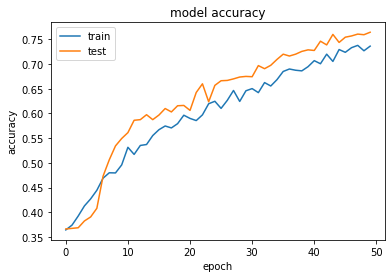

In [10]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

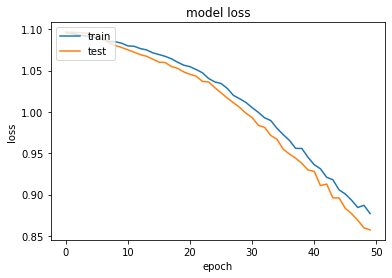

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

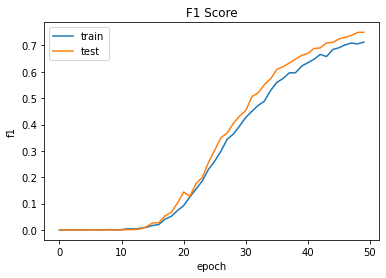

In [12]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

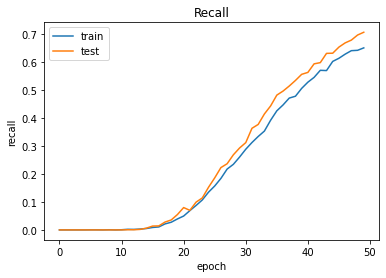

In [13]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

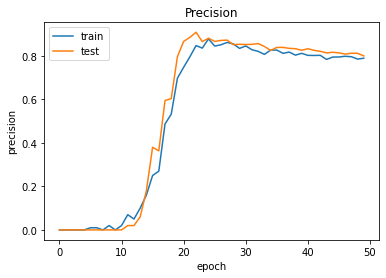

In [14]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
213/213 [==============================] - 22s 102ms/step - loss: 0.8527 - accuracy: 0.7750 - f1_m: 0.7565 - precision_m: 0.8149 - recall_m: 0.7075
El modelo predice el  77.50442028045654 % de los datos


In [16]:
print("Las métricas del modelo son: ",model.metrics_names)

Las métricas del modelo son:  ['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m']


In [18]:
print("Obtenemos las métricas para test, con 50 epocas; ",test_eval)

Obtenemos las métricas para test, con 50 epocas;  [0.8527181422766386, 0.7750442, 0.7565118, 0.8149043, 0.7074531]


In [19]:
from keras.models import model_from_json
# serializar el modelo a JSON
model_json = model.to_json()
with open("ModeloXception50eponchs.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model.save_weights("PesosXception50eponchs.h5")
print("Modelo Guardado!")

Modelo Guardado!


In [20]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=25,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/25
100/100 [==============================] - 47s 468ms/step - loss: 0.8649 - accuracy: 0.7528 - f1_m: 0.7322 - precision_m: 0.7966 - recall_m: 0.6787 - val_loss: 0.8465 - val_accuracy: 0.7706 - val_f1_m: 0.7555 - val_precision_m: 0.8098 - val_recall_m: 0.7094
Epoch 2/25
100/100 [==============================] - 47s 470ms/step - loss: 0.8565 - accuracy: 0.7559 - f1_m: 0.7389 - precision_m: 0.8028 - recall_m: 0.6859 - val_loss: 0.8406 - val_accuracy: 0.7675 - val_f1_m: 0.7573 - val_precision_m: 0.8051 - val_recall_m: 0.7163
Epoch 3/25
100/100 [==============================] - 47s 473ms/step - loss: 0.8584 - accuracy: 0.7456 - f1_m: 0.7345 - precision_m: 0.7987 - recall_m: 0.6812 - val_loss: 0.8404 - val_accuracy: 0.7719 - val_f1_m: 0.7552 - val_precision_m: 0.8042 - val_recall_m: 0.7131
Epoch 4/25
100/100 [==============================] - 48s 477ms/step - loss: 0.8528 - accuracy: 0.74

In [21]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
213/213 [==============================] - 22s 102ms/step - loss: 0.7428 - accuracy: 0.8362 - f1_m: 0.8330 - precision_m: 0.8489 - recall_m: 0.8182
El modelo predice el  83.61815214157104 % de los datos


In [22]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=25,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/25
100/100 [==============================] - 46s 461ms/step - loss: 0.7596 - accuracy: 0.8133 - f1_m: 0.8112 - precision_m: 0.8275 - recall_m: 0.7959 - val_loss: 0.7536 - val_accuracy: 0.8156 - val_f1_m: 0.8124 - val_precision_m: 0.8305 - val_recall_m: 0.7956
Epoch 2/25
100/100 [==============================] - 47s 465ms/step - loss: 0.7639 - accuracy: 0.8112 - f1_m: 0.8076 - precision_m: 0.8295 - recall_m: 0.7875 - val_loss: 0.7521 - val_accuracy: 0.8206 - val_f1_m: 0.8170 - val_precision_m: 0.8318 - val_recall_m: 0.8031
Epoch 3/25
100/100 [==============================] - 47s 474ms/step - loss: 0.7638 - accuracy: 0.8066 - f1_m: 0.8065 - precision_m: 0.8268 - recall_m: 0.7875 - val_loss: 0.7506 - val_accuracy: 0.8163 - val_f1_m: 0.8173 - val_precision_m: 0.8345 - val_recall_m: 0.8012
Epoch 4/25
100/100 [==============================] - 47s 472ms/step - loss: 0.7665 - accuracy: 0.80

In [23]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

  ...
    to  
  ['...']
213/213 [==============================] - 21s 99ms/step - loss: 0.6999 - accuracy: 0.8651 - f1_m: 0.8648 - precision_m: 0.8723 - recall_m: 0.8577
El modelo predice el  86.50559782981873 % de los datos


In [24]:
print("Obtenemos las métricas para test, con 50 epocas; ",test_eval)

Obtenemos las métricas para test, con 50 epocas;  [0.699885776624993, 0.865056, 0.8647856, 0.8723094, 0.8576878]


In [25]:
from keras.models import model_from_json
# serializar el modelo a JSON
model_json = model.to_json()
with open("ModeloXception100eponchs.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model.save_weights("PesosXception100eponchs.h5")
print("Modelo Guardado!")

Modelo Guardado!


Aquí estoy haciendo prubas con los datos del articulo pero como solo son dos clases en el articulo hay problemas al yo entrenar con 3 clases

In [27]:
articulo_dir= 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'

In [29]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

articulo_generator = train_datagen.flow_from_directory(
    articulo_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

Found 234 images belonging to 2 classes.


In [35]:
test_eval = model.predict(articulo_generator)

In [31]:
articulo_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [46]:
import numpy as np
np.argmax(test_eval[198])

0

In [50]:
suma=0
label=np.zeros(233)
for i in range (233):
    if articulo_generator.labels[i]==1:
        label[i]=2
for i in range (233):
    if np.argmax(test_eval[i])==label[i]:
        suma=suma+1
print (suma)

101


In [53]:
for i in range (233):
    print(np.argmax(test_eval[i]))

2
2
2
2
0
0
0
2
2
2
0
0
1
0
2
2
2
2
2
2
0
0
2
2
1
1
2
2
2
0
1
1
1
0
1
2
0
2
0
2
0
0
1
2
2
2
0
2
2
0
0
0
0
0
0
1
2
0
2
0
0
0
1
2
0
0
0
0
2
0
2
0
2
2
2
2
1
2
2
0
0
1
0
0
2
2
0
0
0
0
0
2
0
2
2
2
2
2
2
2
0
2
0
0
0
2
2
2
0
1
0
0
2
0
2
0
2
0
1
2
0
2
0
0
2
1
2
0
1
2
2
1
2
0
0
2
1
2
2
0
2
0
2
0
2
0
0
0
0
2
0
0
2
1
0
0
2
1
0
0
2
2
2
0
2
2
0
0
2
2
2
0
0
0
1
1
2
1
2
2
2
2
0
0
2
1
0
2
2
0
2
2
2
0
2
2
1
1
0
0
2
2
0
0
2
0
0
1
2
0
0
2
1
1
2
0
0
2
2
0
2
0
2
2
0
0
2
2
2
0
0
1
0
